# **미세튜닝된 어댑터 업로드한 ID: yelin1001**

# 강의 11주차: llama2-food-order-understanding

1. llama-2-7b-chat-hf 를 주문 문장 이해에 미세 튜닝

- food-order-understanding-small-3200.json (학습)
- food-order-understanding-small-800.json (검증)


종속적인 필요 내용
- huggingface 계정 설정 및 llama-2 사용 승인
- 로깅을 위한 wandb

**종속성 설치**

In [1]:
pip install transformers peft accelerate optimum bitsandbytes trl wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.3/168.3 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 39.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.9/133.9 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 95.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 40.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.9/100.9 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.8/252.8 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━

**라이브러리 및 모듈 임포트**

> 데이터 처리, 모델 학습, 추론에 사용되는 라이브러리 및 모듈을 포함함.

In [2]:
import os
from dataclasses import dataclass, field
from typing import Optional
import re

import torch
import tyro
from accelerate import Accelerator
from datasets import load_dataset, Dataset
from peft import AutoPeftModelForCausalLM, LoraConfig
from tqdm import tqdm
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
)

from trl import SFTTrainer

from trl.trainer import ConstantLengthDataset

/usr/local/lib/python3.10/dist-packages/trl/trainer/ppo_config.py:141: UserWarning: The `optimize_cuda_cache` arguement will be deprecated soon, please use `optimize_device_cache` instead.
  warnings.warn(


In [3]:
from huggingface_hub import notebook_login

notebook_login()

In [4]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


# 매개 변수 설정


> 스크립트에 사용되는 다양한 인자들을 설정함.





In [5]:
@dataclass
class ScriptArguments:
    cache_dir: Optional[str] = field(
        default=None, metadata={"help": "the cache dir"}
    )
    model_name: Optional[str] = field(
        default="meta-llama/Llama-2-7b-chat-hf", metadata={"help": "the model name"}
    )

    dataset_name: Optional[str] = field(
        default=None,
        metadata={"help": "the dataset name"},
    )
    seq_length: Optional[int] = field(
        default=1024, metadata={"help": "the sequence length"}
    )
    num_workers: Optional[int] = field(
        default=8, metadata={"help": "the number of workers"}
    )
    training_args: TrainingArguments = field(
        default_factory=lambda: TrainingArguments(
            output_dir="./results",
            # max_steps=500,
            logging_steps=20,
            # save_steps=10,
            per_device_train_batch_size=1,
            per_device_eval_batch_size=1,
            gradient_accumulation_steps=2,
            gradient_checkpointing=False,
            group_by_length=False,
            learning_rate=1e-4,
            lr_scheduler_type="cosine",
            # warmup_steps=100,
            warmup_ratio=0.03,
            max_grad_norm=0.3,
            weight_decay=0.05,
            save_total_limit=20,
            save_strategy="epoch",
            num_train_epochs=1,
            optim="paged_adamw_32bit",
            fp16=True,
            remove_unused_columns=False,
            report_to="wandb",
        )
    )

    packing: Optional[bool] = field(
        default=True, metadata={"help": "whether to use packing for SFTTrainer"}
    )

    peft_config: LoraConfig = field(
        default_factory=lambda: LoraConfig(
            #r=8,
            r=16,
            lora_alpha=16,
            #lora_dropout=0.05,
            lora_dropout=0.1,
            target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "down_proj", "up_proj", "gate_proj"],
            bias="none",
            task_type="CAUSAL_LM",
        )
    )

    merge_with_final_checkpoint: Optional[bool] = field(
        default=False, metadata={"help": "Do only merge with final checkpoint"}
    )

# 유틸리티

In [6]:
def chars_token_ratio(dataset, tokenizer, nb_examples=400):
    """
    Estimate the average number of characters per token in the dataset.
    """
    total_characters, total_tokens = 0, 0
    for _, example in tqdm(zip(range(nb_examples), iter(dataset)), total=nb_examples):
        text = prepare_sample_text(example)
        total_characters += len(text)
        if tokenizer.is_fast:
            total_tokens += len(tokenizer(text).tokens())
        else:
            total_tokens += len(tokenizer.tokenize(text))

    return total_characters / total_tokens


def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

# 데이터 로딩

**텍스트 전처리 함수**

> prepare_sample_text 함수는 데이터셋의 각 예제를 전처리하는데 사용됨. 아래 주어진 템플릿으로 텍스트를 생성함.

In [ ]:
def prepare_sample_text(example):
    """Prepare the text from a sample of the dataset."""

    prompt_template = """###System;{System}
    ###User;{User}
    ###Midm;{Midm}"""

    default_system_msg = (
        "너는 사용자가 작성한 리뷰의 긍정 또는 부정을 판단해야 한다."
    )

    text = (
        prompt_template.format(System=default_system_msg,
                               User=example["document"],
                               Midm="긍정" if example["label"]==1 else "부정"
                               )
    )

    return text

**훈련 데이터셋 생성 함수**


> create_train_datasets 함수는 훈련 데이터셋을 생성함. 훈련 데이터 개수를 지정하고 토큰화하여 모델 훈련에 사용될 수 있도록 데이터셋 구성함.



In [ ]:
def create_train_datasets(tokenizer, args):
    dataset = load_dataset(args.dataset_name, cache_dir=args.cache_dir)
    train_data = dataset['train'].select(range(150000))

    chars_per_token = chars_token_ratio(train_data, tokenizer)
    print(f"The character to token ratio of the dataset is: {chars_per_token:.2f}")

    train_dataset = ConstantLengthDataset(
        tokenizer,
        train_data,
        formatting_func=prepare_sample_text,
        infinite=True,
        seq_length=args.seq_length,
        chars_per_token=chars_per_token,# 부가정보, 컨트롤하는 정보
    )

    return train_dataset

**테스트 데이터셋 생성**

> create_valid_datasets 함수는 테스트 데이터셋을 생성함. 테스트 데이터 개수를 지정하고 토큰화하여 모델 추론에 사용될 수 있도록 데이터셋 구성함.



In [7]:
def create_valid_datasets(tokenizer, args):
    dataset = load_dataset(args.dataset_name, cache_dir=args.cache_dir) # nsmc 데이터셋을 허깅페이스에서 가져옴
    valid_data = dataset['test']
    valid_dataset = valid_data.select(range(1000))

    return valid_dataset

# 미세 튜닝용 모델 로딩

In [8]:
script_args = ScriptArguments(
    num_workers=2,
    seq_length=512,
    dataset_name='nsmc',
    model_name='meta-llama/Llama-2-7b-chat-hf',
    )

In [9]:
script_args.training_args.logging_steps = 100
script_args.training_args.max_steps = 1600
script_args.training_args.output_dir = '/gdrive/MyDrive/nlp/lora-llama-2-7b-nsmc'
script_args.training_args.run_name = 'llama-2-7b-nsmc'

In [ ]:
print(script_args)

ScriptArguments(cache_dir=None, model_name='meta-llama/Llama-2-7b-chat-hf', dataset_name='nsmc', seq_length=512, num_workers=2, training_args=TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=False,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=no,
fp16=True,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_config={'min_num_params': 0, 'xla': False, 'xla_fsdp_grad_ckpt': False},
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False,
gradient_accumulation_steps=

**4비트 양자화**


> 데이터를 4비트로 양자화하여 로드함



In [ ]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

**사전 훈련된 모델 로딩**

In [ ]:
base_model = AutoModelForCausalLM.from_pretrained(
    script_args.model_name,
    quantization_config=bnb_config,
    device_map="auto",  # {"": Accelerator().local_process_index},
    trust_remote_code=True,
    use_auth_token=True,
    cache_dir=script_args.cache_dir,
)
base_model.config.use_cache = False

/usr/local/lib/python3.10/dist-packages/transformers/models/auto/auto_factory.py:472: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/utils/hub.py:374: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

In [ ]:
base_model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear4bit(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm

In [ ]:
peft_config = script_args.peft_config

In [ ]:
peft_config

LoraConfig(peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path=None, revision=None, task_type='CAUSAL_LM', inference_mode=False, r=16, target_modules={'v_proj', 'down_proj', 'gate_proj', 'up_proj', 'o_proj', 'q_proj', 'k_proj'}, lora_alpha=16, lora_dropout=0.2, fan_in_fan_out=False, bias='none', modules_to_save=None, init_lora_weights=True, layers_to_transform=None, layers_pattern=None, rank_pattern={}, alpha_pattern={}, megatron_config=None, megatron_core='megatron.core', loftq_config={})

**토크나이저 초기화 및 토크나이저, 모델 설정**

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(
    script_args.model_name,
    trust_remote_code=True,
    cache_dir=script_args.cache_dir,
)

if getattr(tokenizer, "pad_token", None) is None:
    tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"  # Fix weird overflow issue with fp16 training

base_model.config.pad_token_id = tokenizer.pad_token_id

tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

In [ ]:
training_args = script_args.training_args

**데이터셋 생성**

In [ ]:
train_dataset = create_train_datasets(tokenizer, script_args)
valid_dataset = create_valid_datasets(tokenizer, script_args)

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/150000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

100%|██████████| 400/400 [00:00<00:00, 2204.97it/s]
/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:548: UserWarning: The passed formatting_func has more than one argument. Usually that function should have a single argument `example` which corresponds to the dictionary returned by each element of the dataset. Make sure you know what you are doing.
  warnings.warn(


The character to token ratio of the dataset is: 0.87


In [ ]:
len(train_dataset)

150000

**SFTTrainer 초기화**


>



In [ ]:
trainer = SFTTrainer(
    model=base_model,
    formatting_func=prepare_sample_text,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    peft_config=peft_config,
    packing=script_args.packing,
    max_seq_length=script_args.seq_length,
    tokenizer=tokenizer,
    args=training_args,
)

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:267: UserWarning: You passed `packing=True` to the SFTTrainer, and you are training your model with `max_steps` strategy. The dataset will be iterated until the `max_steps` are reached.
  warnings.warn(


In [ ]:
base_model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): lora.Linear4bit(
            (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
            (lora_dropout): ModuleDict(
              (default): Dropout(p=0.2, inplace=False)
            )
            (lora_A): ModuleDict(
              (default): Linear(in_features=4096, out_features=16, bias=False)
            )
            (lora_B): ModuleDict(
              (default): Linear(in_features=16, out_features=4096, bias=False)
            )
            (lora_embedding_A): ParameterDict()
            (lora_embedding_B): ParameterDict()
          )
          (k_proj): lora.Linear4bit(
            (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
            (lora_dropout): ModuleDict(
              (default): Dropout(p=0.2, inplace=False)
   

**base_model 장치 확인**


> device 속성은 모델이 CPU에 있는지 GPU에 있는지 알려줌.



In [ ]:
base_model.device


device(type='cuda', index=0)

**학습 가능한 파라미터 정보**

In [ ]:
print_trainable_parameters(base_model)

trainable params: 39976960 || all params: 3540389888 || trainable%: 1.1291682911958425


In [ ]:
trainer.train()


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


TrainOutput(global_step=1600, training_loss=0.8062745618820191, metrics={'train_runtime': 6123.2885, 'train_samples_per_second': 0.523, 'train_steps_per_second': 0.261, 'total_flos': 6.53458201903104e+16, 'train_loss': 0.8062745618820191, 'epoch': 0.02})

구글 코랩 T-4 GPU: 1:37:34 예상시간
- 총 1,600 스텝 필요
- 하지만 이보다 일찍 종료됨 약 900번 미만 스텝에서 종료됨

시퀀스 길이 512의 경우
- 14.4 G / 15.0 G 사용
- 메모리 오버플로우 발생시 512보다 줄일 것

In [ ]:
script_args.training_args.output_dir

'/gdrive/MyDrive/nlp/lora-llama-2-7b-nsmc'

In [ ]:
trainer.save_model(script_args.training_args.output_dir)

# 추론 테스트

In [ ]:
from transformers import pipeline, TextStreamer

In [ ]:
instruction_prompt_template = """###System;다음은 네이버 영화 리뷰들을 모아놓은 문장이다. 이를 분석하여 사용자가 작성한 영화 리뷰의 감정을 긍정 또는 부정으로 예측하라.

### 리뷰 내용: {0} ### 분석 결과:
"""

prompt_template = """###System;{System}
###User;{User}
###Midm;"""

default_system_msg = (
        "너는 먼저 사용자가 작성한 영화 리뷰의 감정을 분석하는 에이전트이다. 이로부터 긍정 또는 부정을 판단해야 한다."
)

In [ ]:
def wrapper_generate(model, input_prompt):
    data = tokenizer(input_prompt, return_tensors="pt")
    streamer = TextStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)
    input_ids = data.input_ids[..., :-1]
    with torch.no_grad():
        pred = model.generate(
            input_ids=input_ids.cuda(),
            #input_ids = input_ids.to('cuda'),
            streamer=streamer,
            use_cache=True,
            max_new_tokens=float('inf'),
            temperature=0.5
        )
    decoded_text = tokenizer.batch_decode(pred, skip_special_tokens=True)
    return (decoded_text[0][len(input_prompt):])

In [ ]:
eval_dic = {i: wrapper_generate(model=base_model, input_prompt=prompt_template.format(System=default_system_msg, User=example["document"]))for i, example in enumerate(valid_dataset)}

;부정
;긍정
;부정
;부정
;부정
;긍정
;부정
;부정
;부정
;긍정
;긍정
;부정
;긍정
;긍정
;부정
;긍정
;긍정
;부정
;긍정
;부정
;긍정
;부정
;긍정
;긍정
;부정
;부정
;긍정
;긍정
;부정
;긍정
;긍정
;긍정
;부정
;긍정
;부정
;부정
;부정
;긍정
;부정
;부정
;부정
;부정
;부정
;긍정
;부정
;긍정
;긍정
;부정
;긍정
;긍정
;부정
;긍정
;부정
;긍정
;긍정
;긍정
;부정
;긍정
;긍정
;긍정
;긍정
;부정
;부정
;부정
;긍정
;부정
;긍정
;긍정
;긍정
;긍정
;부정
;부정
;부정
;부정
;부정
;긍정
;긍정
;긍정
;긍정
;부정
;부정
;긍정
;부정
;긍정
;부정
;긍정
;긍정
;부정
;긍정
;부정
;부정
;부정
;부정
;긍정
;부정
;부정
;긍정
;긍정
;부정
;긍정
;부정
;긍정
;긍정
;긍정
;긍정
;부정
;긍정
;부정
;부정
;긍정
;부정
;긍정
;긍정
;긍정
;긍정
;부정
;부정
;긍정
;긍정
;긍정
;부정
;부정
;긍정
;긍정
;부정
;긍정
;부정
;긍정
;부정
;긍정
;부정
;부정
;부정
;긍정
;긍정
;부정
;긍정
;긍정
;긍정
;긍정
;부정
;부정
;긍정
;긍정
;부정
;긍정
;부정
;부정
;부정
;부정
;긍정
;부정
;긍정
;긍정
;긍정
;긍정
;긍정
;부정
;긍정
;부정
;긍정
;긍정
;긍정
;부정
;부정
;부정
;긍정
;긍정
;긍정
;부정
;부정
;부정
;부정
;긍정
;부정
;부정
;긍정
;긍정
;부정
;긍정
;긍정
;부정
;부정
;부정
;긍정
;긍정
;부정
;부정
;부정
;긍정
;긍정
;부정
;긍정
;긍정
;긍정
;부정
;부정
;긍정
;부정
;부정
;긍정
;긍정
;긍정
;긍정
;긍정
;부정
;긍정
;부정
;부정
;긍정
;부정
;긍정
;긍정
;긍정
;부정
;부정
;부정
;긍정
;부정
;부정
;긍정
;긍정
;부정
;부정
;부정
;긍정
;긍정
;부정
;긍정
;긍정
;부정
;부정
;긍정
;부정
;긍정
;부정
;부정
;긍정
;부정
;부정
;부정
;부정
;긍정
;긍정
;부정
;긍정
;긍정
;긍정
;긍정
;부정


In [ ]:
print(eval_dic[8])

부정


# 미세튜닝된 모델 로딩 후 테스트

In [10]:
from transformers import pipeline, TextStreamer

**프롬프트 정의**


> 사용자 영화 리뷰의 예측을 생성하기 위한 프롬프트 정의함.



In [11]:
instruction_prompt_template = """###System;다음은 네이버 영화 리뷰들을 모아놓은 문장이다. 이를 분석하여 사용자가 작성한 영화 리뷰의 감정을 긍정 또는 부정으로 예측하라.

### 리뷰 내용: {0} ### 분석 결과:
"""

prompt_template = """###System;{System}
###User;{User}
###Midm;"""

default_system_msg = (
        "너는 사용자가 작성한 리뷰의 긍정 또는 부정을 판단해야 한다."
)

**wrapper_generate 함수**


> 사용자 영화 리뷰에 대한 입력 프롬프트 생성.



In [12]:
def wrapper_generate(model, input_prompt):
    data = tokenizer(input_prompt, return_tensors="pt")
    streamer = TextStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)
    input_ids = data.input_ids[..., :-1]
    with torch.no_grad():
        pred = model.generate(
            input_ids=input_ids.cuda(),
            streamer=streamer,
            use_cache=True,
            max_new_tokens=float('inf'),
            temperature=0.5
        )
    decoded_text = tokenizer.batch_decode(pred, skip_special_tokens=True)
    return (decoded_text[0][len(input_prompt):])

**양자화 설정**


> 4비트로 양자화함.



In [13]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

**모델 불러오기**

> 미세튜닝된 모델을 4비트로 양자화하여 저장된 모델을 가져옴.



In [14]:
trained_model = AutoPeftModelForCausalLM.from_pretrained(
    script_args.training_args.output_dir,
    quantization_config=bnb_config,
    device_map="auto",
    cache_dir=script_args.cache_dir,
)

config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

**토크나이저 초기화**


> 지정된 모델에서 미리 훈련된 토크나이저를 로드함.



In [15]:
tokenizer = AutoTokenizer.from_pretrained(
    script_args.model_name,
    trust_remote_code=True,
    cache_dir=script_args.cache_dir,
)

if getattr(tokenizer, "pad_token", None) is None:
    tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"  # Fix weird overflow issue with fp16 training
trained_model.config.pad_token_id = tokenizer.pad_token_id

tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

**데이터셋 생성**


> 추론에 사용할 테스트 데이터 생성함.



In [16]:
valid_dataset = create_valid_datasets(tokenizer, script_args)

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/150000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

추론 과정에서는 GPU 메모리를 약 5.5 GB 활용

In [17]:
eval_dic = {i: wrapper_generate(model=trained_model, input_prompt=prompt_template.format(System=default_system_msg, User=example["document"]))for i, example in enumerate(valid_dataset)}

;긍정
;긍정
;부정
;부정
;부정
;긍정
;부정
;부정
;부정
;긍정
;긍정
;부정
;긍정
;긍정
;부정
;부정
;긍정
;부정
;긍정
;부정
;긍정
;부정
;긍정
;긍정
;부정
;부정
;긍정
;긍정
;부정
;긍정
;긍정
;긍정
;부정
;긍정
;부정
;부정
;부정
;부정
;부정
;부정
;부정
;부정
;부정
;긍정
;부정
;긍정
;긍정
;부정
;긍정
;긍정
;부정
;긍정
;부정
;긍정
;긍정
;긍정
;부정
;부정
;긍정
;긍정
;긍정
;부정
;부정
;부정
;긍정
;긍정
;긍정
;긍정
;긍정
;긍정
;부정
;부정
;부정
;부정
;부정
;긍정
;긍정
;긍정
;긍정
;부정
;부정
;긍정
;긍정
;긍정
;부정
;긍정
;긍정
;부정
;긍정
;부정
;부정
;부정
;부정
;긍정
;부정
;부정
;긍정
;긍정
;부정
;긍정
;부정
;부정
;긍정
;부정
;긍정
;부정
;긍정
;부정
;부정
;긍정
;부정
;긍정
;긍정
;긍정
;긍정
;부정
;부정
;긍정
;긍정
;긍정
;부정
;부정
;긍정
;긍정
;부정
;긍정
;부정
;긍정
;부정
;긍정
;긍정
;부정
;부정
;긍정
;긍정
;부정
;긍정
;긍정
;긍정
;긍정
;부정
;부정
;긍정
;긍정
;부정
;긍정
;부정
;부정
;부정
;부정
;긍정
;부정
;긍정
;긍정
;긍정
;긍정
;긍정
;부정
;긍정
;부정
;긍정
;긍정
;부정
;부정
;긍정
;부정
;긍정
;긍정
;긍정
;부정
;부정
;부정
;부정
;긍정
;긍정
;부정
;긍정
;긍정
;부정
;긍정
;긍정
;부정
;부정
;부정
;긍정
;긍정
;부정
;부정
;부정
;긍정
;긍정
;부정
;긍정
;긍정
;긍정
;부정
;긍정
;긍정
;부정
;부정
;긍정
;긍정
;긍정
;긍정
;긍정
;부정
;긍정
;부정
;부정
;긍정
;부정
;긍정
;부정
;긍정
;부정
;부정
;부정
;긍정
;부정
;부정
;긍정
;부정
;부정
;부정
;부정
;긍정
;긍정
;긍정
;긍정
;부정
;부정
;부정
;긍정
;부정
;긍정
;부정
;부정
;긍정
;부정
;부정
;부정
;부정
;긍정
;긍정
;부정
;긍정
;긍정
;긍정
;긍정
;부정


**모델 평가 및 결과**


> 정확도 및 혼돈 행렬로 모델을 평가함.



Accuracy: 0.869


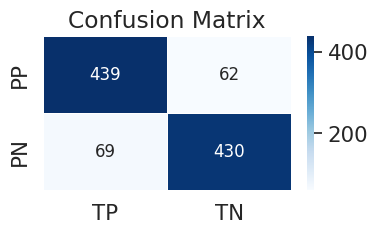

Precision: 0.8762475049900199
Recall: 0.8641732283464567
F1 Score: 0.8701684836471754 

Classification Report:
               precision    recall  f1-score   support

    Negative       0.86      0.87      0.87       492
    Positive       0.88      0.86      0.87       508

    accuracy                           0.87      1000
   macro avg       0.87      0.87      0.87      1000
weighted avg       0.87      0.87      0.87      1000



In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report

true_labels = [example["label"] for example in valid_dataset]

predicted_labels = [1 if "긍정" in eval_dic[i] else 0 for i in range(len(valid_dataset))]

conf_matrix = confusion_matrix(true_labels, predicted_labels)

accuracy = accuracy_score(true_labels, predicted_labels)

TN = conf_matrix[0, 0] if len(conf_matrix) > 1 else 0
TP = conf_matrix[1, 1] if len(conf_matrix) > 1 else 0
FP = conf_matrix[0, 1] if len(conf_matrix) > 1 else 0
FN = conf_matrix[1, 0] if len(conf_matrix) > 1 else 0

# 강의자료 표처럼 만들기 위해 TP, TN 위치 바꿈
conf_matrix[0, 0] = TP
conf_matrix[1, 1] = TN

# PP, PN
data = {
    'True Positive (TP)': [TP, FN],
    'True Negative (TN)': [FP, TN],
}

df_2x2 = pd.DataFrame(data, index=['Predicted Positive (PP)', 'Predicted Negative (PN)'])

print("Accuracy:", accuracy)
#print(df_2x2)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(4,2))
sns.set(font_scale=1.4)  # 폰트 크기 조절

# 히트맵 생성
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", linewidths=.5, annot_kws={"size": 12})
plt.xticks(ticks=[0.5, 1.5], labels=['TP', 'TN'])
plt.yticks(ticks=[0.5, 1.5], labels=['PP', 'PN'])
plt.title('Confusion Matrix')
plt.show()

# 정밀도, 재현율, F1 점수 계산
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1, "\n")

# 분류 리포트 출력
class_report = classification_report(true_labels, predicted_labels, target_names=['Negative', 'Positive'])
print("Classification Report:\n", class_report)

# 테스트 데이터에 대한 분류 결과 리포트

**모델 평가 결과**

> 정확도 : 0.869

> 정밀도 : 0.876

> 재현율 : 0.864

> F1 점수 : 0.870

> Confusion Matrix

>  |  | TP | TN |
|----------|----------|----------|
| PP | 439 | 62 |
| PN | 69 | 430 |

>

**결과 분석**

> 정확도는 0.869로 모델이 1000개 테스트 데이터 중 869개에 대해 정확한 예측을 수행했다.

> TP : 439, TN : 430, FP : 62, FN : 69의 결과가 나왔다. FP와 FN의 값을 봤을 때, 미세튜닝된 모델은 비슷하게 잘못 예측했다.

